# DX 704 Week 1 Project

This week's project will build a portfolio risk and return model, and make investing recommendations for hypothetical clients.
You will collect historical data, estimate returns and risks, construct efficient frontier portfolios, and sanity check the certainty of the maximum return portfolio.

The full project description and a template notebook are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-01


Feel free to use optimization tools or libraries (such as CVXOPT or scipy.optimize) to perform any calculations required for this mini project.

### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Collect Data

Collect historical monthly price data for the last 24 months covering 6 different stocks.
The data should cover 24 consecutive months including the last month that ended before this week's material was released on Blackboard.
To be clear, if a month ends between the Blackboard release and submitting your project, you do not need to add that month.

The six different stocks must include AAPL, SPY and TSLA.
At least one of the remaining 3 tickers must start with the same letter as your last name (e.g. professor Considine could use COIN).
This is to encourage diversity in what stocks you analyze; if you discuss this project with classmates, please make sure that you pick different tickers to differentiate your work.
Do not pick stocks with fewer than 24 consecutive months of price data.

In [41]:
# Load libraries
import pandas as pd
import yfinance as yf
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Turn off scientific notation for pandas and numpy
pd.options.display.float_format = "{:.6f}".format
np.set_printoptions(suppress=True, formatter={"float_kind": "{:.6f}".format})

In [2]:
# YOUR CHANGES HERE
# Specify stocks
tickers = ["AAPL", "SPY", "TSLA", "PEP", "PYPL", "MSFT"]

# Specify monthd
start_month = "2023-09-01"  
end_month_exclusive = "2025-09-01" 
target_months = pd.period_range("2023-09", "2025-08", freq="M")  


In [3]:
# Let's dowload daily data 
raw = yf.download(
    tickers=tickers,
    start=start_month,
    end=end_month_exclusive,
    auto_adjust=False,            
    progress=False,
    group_by="column",           
)

In [4]:
# Take a look
raw.head()

Price        Adj Close                                                 \
Ticker            AAPL        MSFT         PEP       PYPL         SPY   
Date                                                                    
2023-09-01  187.622269  323.780670  163.701630  63.570000  439.492157   
2023-09-05  187.859909  328.597992  162.618500  63.740002  437.592712   
2023-09-06  181.135788  327.938019  163.150681  62.799999  434.651001   
2023-09-07  175.837677  325.012054  164.710022  61.650002  433.316498   
2023-09-08  176.451660  329.307312  164.588669  60.980000  433.969147   

Price                        Close                                     ...  \
Ticker            TSLA        AAPL        MSFT         PEP       PYPL  ...   
Date                                                                   ...   
2023-09-01  245.009995  189.460007  328.660004  175.320007  63.570000  ...   
2023-09-05  256.489990  189.699997  333.549988  174.160004  63.740002  ...   
2023-09-06  251.919998  182.910004  332.880005  174.729996  62.799999  ...   
2023-09-07  251.490005  177.559998  329.910004  176.399994  61.650002  ...   
2023-09-08  248.500000  178.179993  334.269989  176.270004  60.980000  ...   

Price             Open                                        Volume  \
Ticker             PEP       PYPL         SPY        TSLA       AAPL   
Date                                                                   
2023-09-01  178.729996  63.130001  453.170013  257.260010   45766500   
2023-09-05  175.270004  63.380001  450.730011  245.000000   45280000   
2023-09-06  174.919998  63.119999  448.399994  255.139999   81755800   
2023-09-07  175.850006  62.000000  443.109985  245.070007  112488800   
2023-09-08  175.809998  61.580002  444.899994  251.220001   65551300   

Price                                                         
Ticker          MSFT      PEP      PYPL       SPY       TSLA  
Date                                                          
2023-09-01  14942000  4801400  11715200  58944100  132541600  
2023-09-05  18553900  5081800  12739100  55166200  129469600  
2023-09-06  17535800  5933800  13621300  70758500  116959800  
2023-09-07  18381000  4934300  12712700  70355400  115312900  
2023-09-08  19530100  2995000  15367400  61659700  118367700  

[5 rows x 36 columns]

In [5]:
raw.shape

(500, 36)

In [6]:
# Take only the adjusted price 
adj_close = raw["Adj Close"]


In [7]:
adj_close.head()

Ticker,AAPL,MSFT,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-01,187.622269,323.780670,163.701630,63.570000,439.492157,245.009995
2023-09-05,187.859909,328.597992,162.618500,63.740002,437.592712,256.489990
2023-09-06,181.135788,327.938019,163.150681,62.799999,434.651001,251.919998
2023-09-07,175.837677,325.012054,164.710022,61.650002,433.316498,251.490005
2023-09-08,176.451660,329.307312,164.588669,60.980000,433.969147,248.500000


In [8]:
adj_close.shape

(500, 6)

In [9]:
# Resample to month-end prices (last trading day each month)
monthly_prices = adj_close.resample("ME").last()

In [10]:
monthly_prices.head()

Ticker,AAPL,MSFT,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-30,169.549286,311.062347,158.211288,58.459999,417.865631,250.220001
2023-10-31,169.113556,333.090332,152.459488,51.799999,408.794373,200.839996
2023-11-30,188.355316,374.042267,158.335693,57.610001,446.135193,240.080002
2023-12-31,190.913666,371.209137,159.794022,61.410000,466.503693,248.479996
2024-01-31,182.851898,392.472443,158.561508,61.349998,473.933411,187.289993


In [11]:
monthly_prices.shape

(24, 6)

In [12]:
# Check if all have 24 months of data
print(monthly_prices.isna().any())

Ticker
AAPL    False
MSFT    False
PEP     False
PYPL    False
SPY     False
TSLA    False
dtype: bool


In [13]:
monthly_prices.head()

Ticker,AAPL,MSFT,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-30,169.549286,311.062347,158.211288,58.459999,417.865631,250.220001
2023-10-31,169.113556,333.090332,152.459488,51.799999,408.794373,200.839996
2023-11-30,188.355316,374.042267,158.335693,57.610001,446.135193,240.080002
2023-12-31,190.913666,371.209137,159.794022,61.410000,466.503693,248.479996
2024-01-31,182.851898,392.472443,158.561508,61.349998,473.933411,187.289993


Save the data as a TSV file named "historical_prices.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
The date should be the last trading day of the month, so it may not be the last day of the month.
For example, the last trading day of November 2024 was 2024-11-29.
The remaining columns should contain the adjusted closing prices of the corresponding stock tickers on that day.


In [14]:
# YOUR CHANGES HERE

# Fix index
monthly_prices = monthly_prices.reset_index()
monthly_prices.rename(columns={"Date": "date"}, inplace=True)

# Set 'date' as the index
monthly_prices = monthly_prices.set_index("date")

# Remove the column index name ("Ticker")
monthly_prices.columns.name = None

# Make sure no index name sneaks in
monthly_prices.index.name = "date"   

# Save as TSV 
monthly_prices.to_csv("historical_prices.tsv", sep="\t", index=False)

In [15]:
monthly_prices.head()

,AAPL,MSFT,PEP,PYPL,SPY,TSLA
date,,,,,,
2023-09-30,169.549286,311.062347,158.211288,58.459999,417.865631,250.220001
2023-10-31,169.113556,333.090332,152.459488,51.799999,408.794373,200.839996
2023-11-30,188.355316,374.042267,158.335693,57.610001,446.135193,240.080002
2023-12-31,190.913666,371.209137,159.794022,61.410000,466.503693,248.479996
2024-01-31,182.851898,392.472443,158.561508,61.349998,473.933411,187.289993


Submit "historical_prices.tsv" in Gradescope.

## Part 2: Calculate Historical Asset Returns

Calculate the historical asset returns based on the price data that you previously collected.

In [16]:
# YOUR CHANGES HERE

historical_returns = monthly_prices.pct_change().dropna()
estimated_returns = historical_returns.mean().rename("return")
estimated_returns.sort_values()

PEP    -0.002383
PYPL    0.011472
AAPL    0.015442
SPY     0.019666
MSFT    0.023318
TSLA    0.025313
Name: return, dtype: float64

Save the data as a TSV file named "historical_returns.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
Each row should have the date at the end of the month and the corresponding *relative* price changes.
For example, if the previous price was \$100 and the new price is \$110, the return value should be 0.10.
There should only be 23 rows of data in this file, since they are computed as the differences of 24 prices.

In [17]:
# YOUR CHANGES HERE

# Reset index so date becomes a column
historical_returns = historical_returns.reset_index()

# Save as TSV with header row (date + tickers)
historical_returns.to_csv("historical_returns.tsv", sep="\t", index=False)

In [18]:
historical_returns.head()

,date,AAPL,MSFT,PEP,PYPL,SPY,TSLA
0,2023-10-31,-0.002570,0.070815,-0.036355,-0.113924,-0.021709,-0.197346
1,2023-11-30,0.113780,0.122945,0.038543,0.112162,0.091344,0.195379
2,2023-12-31,0.013583,-0.007574,0.009210,0.065961,0.045655,0.034988
3,2024-01-31,-0.042227,0.057281,-0.007713,-0.000977,0.015926,-0.246257
4,2024-02-29,-0.018543,0.042318,-0.011441,-0.016463,0.052187,0.077901


In [19]:
historical_returns.shape

(23, 7)

Submit "historical_returns.tsv" in Gradescope.

## Part 3: Estimate Returns

Estimate the expected returns for each asset using the previously calculated return data.
Just compute the average (mean) return for each asset over your data set; do not use other estimators that have been mentioned.
This will serve as your estimate of expected return for each asset.

In [20]:
# YOUR CHANGES HERE
# We calculated estimated returns before to not have datetime column
print(estimated_returns)

AAPL    0.015442
MSFT    0.023318
PEP    -0.002383
PYPL    0.011472
SPY     0.019666
TSLA    0.025313
Name: return, dtype: float64


In [21]:
estimated_returns.shape

(6,)

Save the estimated returns in a TSV file named "estimated_returns.tsv" and include a header row with the column names "asset" and "estimated_return".

In [22]:
# YOUR CHANGES HERE

estimated_returns = estimated_returns.reset_index()
estimated_returns.rename(columns={"index": "asset"}, inplace=True)

# Save to TSV
estimated_returns.to_csv("estimated_returns.tsv", sep="\t", index=False)

In [23]:
estimated_returns.head(10)

,asset,return
0,AAPL,0.015442
1,MSFT,0.023318
2,PEP,-0.002383
3,PYPL,0.011472
4,SPY,0.019666
5,TSLA,0.025313


Submit "estimated_returns.tsv" in Gradescope.

## Part 4: Estimate Risk

Estimate the covariance matrix for the asset returns to understand how the assets move together.

In [24]:
# YOUR CHANGES HERE
# Covariance matrix:
returns_only = historical_returns.drop(columns=["date"], errors="ignore")

estimated_covariance = returns_only.cov()
estimated_variances = returns_only.var()

In [25]:
estimated_variances

AAPL    0.003627
MSFT    0.004044
PEP     0.001549
PYPL    0.007074
SPY     0.001292
TSLA    0.026703
dtype: float64

In [26]:
estimated_covariance

,AAPL,MSFT,PEP,PYPL,SPY,TSLA
AAPL,0.003627,0.000389,0.000640,0.000048,0.000832,0.003254
MSFT,0.000389,0.004044,-0.000580,0.000332,0.001488,0.002217
PEP,0.000640,-0.000580,0.001549,0.000862,0.000381,-0.000827
PYPL,0.000048,0.000332,0.000862,0.007074,0.001437,0.007404
SPY,0.000832,0.001488,0.000381,0.001437,0.001292,0.002421
TSLA,0.003254,0.002217,-0.000827,0.007404,0.002421,0.026703


Save the estimated covariances to a TSV file named "estimated_covariance.tsv".
The header row should have a blank column name followed by the names of the assets.
Each data row should start with the name of an asset for that row, and be followed by the individual covariances corresponding to that row and column's assets.
(This is the format of pandas's `to_csv` method with `sep="\t"` when used on a covariance matrix as computed in the examples.)

In [27]:
# YOUR CHANGES HERE

estimated_covariance.to_csv("estimated_covariance.tsv", sep="\t")

Submit "estimated_covariance.tsv" in Gradescope.

## Part 5: Construct the Maximum Return Portfolio

Compute the maximum return portfolio based on your previously estimated risks and returns.

In [ ]:
# Convert estimated_returns to Series 
estimated_returns = (
    estimated_returns
    .set_index("asset")["return"]
    .astype(float)
)

# Align covariance to the same ticker order 
estimated_covariance = (
    estimated_covariance
    .reindex(index=estimated_returns.index, columns=estimated_returns.index)
    .astype(float)
)

# Numpy arrays for cvxpy
mu = estimated_returns.values.astype(float)                  
Sigma = estimated_covariance.values.astype(float)           
n = len(mu)

# Max-return portfolio 
x_max = cp.Variable(n)
prob_max = cp.Problem(cp.Maximize(mu @ x_max),
                      [x_max >= 0,
                       cp.sum(x_max) == 1])
_ = prob_max.solve()

w_max = np.array(x_max.value, dtype=float)
ret_max = float(mu @ w_max)
var_max = float(w_max @ Sigma @ w_max)
std_max = float(np.sqrt(var_max))


print("Maximum-return portfolio (weights):")
for asset, w in zip(estimated_returns.index.tolist(), w_max):
    print(f"  {asset}: {w:.4f}")
print(f"\nExpected monthly return: {ret_max:.6f}")
print(f"Monthly variance:        {var_max:.6f}")
print(f"Monthly std. dev.:       {std_max:.6f}")


Maximum-return portfolio (weights):
  AAPL: 0.0000
  MSFT: 0.0000
  PEP: 0.0000
  PYPL: 0.0000
  SPY: 0.0000
  TSLA: 1.0000

Expected monthly return: 0.025313
Monthly variance:        0.026703
Monthly std. dev.:       0.163412


Save the maximum return portfolio in a TSV file named "maximum_return.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [32]:
# YOUR CHANGES HERE

# Build a DataFrame with asset and allocation
max_return_portfolio = (
    pd.Series(w_max, index=estimated_returns.index, name="allocation")
    .rename_axis("asset")
    .reset_index()
)

# Save to TSV
max_return_portfolio.to_csv("maximum_return.tsv", sep="\t", index=False)



In [33]:
max_return_portfolio

,asset,allocation
0,AAPL,0.000000
1,MSFT,0.000000
2,PEP,0.000000
3,PYPL,0.000000
4,SPY,0.000000
5,TSLA,1.000000


Submit "maximum_return.tsv" in Gradescope.

## Part 6: Construct the Minimum Risk Portfolio

Compute the minimum risk portfolio based on your previously estimated risks.

In [ ]:
# YOUR CHANGES HERE

# estimated_covariance
assets = estimated_covariance.index.tolist()
Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)   # just to be explicit
    .astype(float)
    .values
)


if isinstance(estimated_returns, pd.DataFrame):
    # handle the case where it's a 2-col DF (asset, return)
    if {"asset", "return"}.issubset(estimated_returns.columns):
        mu_s = estimated_returns.set_index("asset")["return"].astype(float).reindex(assets)
    else:
        mu_s = estimated_returns.squeeze("columns").astype(float).reindex(assets)
else:
    mu_s = pd.Series(estimated_returns, index=getattr(estimated_returns, "index", assets), dtype=float).reindex(assets)

mu = mu_s.values.astype(float)  


n = len(assets)
x_min = cp.Variable(n)
prob_min = cp.Problem(
    cp.Minimize(cp.quad_form(x_min, Sigma)),
    [x_min >= 0, cp.sum(x_min) == 1]
)
var_min = prob_min.solve()

w_min = np.array(x_min.value, dtype=float)
std_min = float(np.sqrt(var_min))
ret_min = float(mu @ w_min)  


print("Minimum-risk (GMV) portfolio weights:")
for a, w in zip(assets, w_min):
    print(f"  {a}: {w:.6f}")
print(f"\nGMV variance:  {var_min:.6f}")
print(f"GMV st. dev.:  {std_min:.6f}")
print(f"GMV exp. ret.: {ret_min:.6f}") 

Minimum-risk (GMV) portfolio weights:
  AAPL: 0.060318
  MSFT: 0.194669
  PEP: 0.531236
  PYPL: 0.000000
  SPY: 0.208909
  TSLA: 0.004867

GMV variance:  0.000824
GMV st. dev.:  0.028707
GMV exp. ret.: 0.008436


Save the minimum risk portfolio in a TSV file named "minimum_risk.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [37]:
# YOUR CHANGES HERE

min_risk_df = pd.DataFrame({
    "asset": assets,          
    "allocation": w_min       
})

# Allocations sum to 1
assert abs(min_risk_df["allocation"].sum() - 1.0) < 1e-8, "Weights do not sum to 1!"

# Save to TSV
min_risk_df.to_csv("minimum_risk.tsv", sep="\t", index=False, float_format="%.6f")

In [38]:
min_risk_df

,asset,allocation
0,AAPL,0.060318
1,MSFT,0.194669
2,PEP,0.531236
3,PYPL,0.000000
4,SPY,0.208909
5,TSLA,0.004867


Submit "minimum_risk.tsv" in Gradescope.

## Part 7: Build Efficient Frontier Portfolios

Compute 101 portfolios along the mean-variance efficient frontier with evenly spaced estimated returns.
The first portfolio should be the minimum risk portfolio from part 4, and the last portfolio should be the maximum return portfolio from part 3.
The estimated return of each portfolio should be higher than the previous by one percent of the difference between the first and last portfolios.
That is, the estimated return of the portfolios should be similar to `np.linspace(min_risk_return, max_return, 101)`.


In [42]:
# YOUR CHANGES HERE

if isinstance(estimated_returns, pd.DataFrame):
    if {"asset", "return"}.issubset(estimated_returns.columns):
        mu_s = estimated_returns.set_index("asset")["return"].astype(float)
    else:
        mu_s = estimated_returns.squeeze("columns").astype(float)
else:
    mu_s = pd.Series(estimated_returns, dtype=float)

assets = mu_s.index.tolist()
mu = mu_s.values.astype(float)  # shape (n,)

# Align covariance to the same order of tickers
Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)
    .astype(float)
    .values
)
n = len(assets)

# Minimum-risk portfolio
x_min = cp.Variable(n)
prob_min = cp.Problem(cp.Minimize(cp.quad_form(x_min, Sigma)),
                      [x_min >= 0, cp.sum(x_min) == 1])
var_min = prob_min.solve()
w_min = np.array(x_min.value, dtype=float)
ret_min = float(mu @ w_min)

# Maximum-return portfolio 
x_max = cp.Variable(n)
prob_max = cp.Problem(cp.Maximize(mu @ x_max),
                      [x_max >= 0, cp.sum(x_max) == 1])
_ = prob_max.solve()
w_max = np.array(x_max.value, dtype=float)
ret_max = float(mu @ w_max)

# 101 evenly spaced target returns 
r_grid = np.linspace(ret_min, ret_max, 101)

ef_returns = []
ef_variances = []
ef_portfolios = []


last_x = w_min  
for r in r_grid:
    x = cp.Variable(n)
    constraints = [x >= 0, cp.sum(x) == 1, mu @ x == r]
    obj = cp.Minimize(cp.quad_form(x, Sigma))
    prob = cp.Problem(obj, constraints)
    try:
        _ = prob.solve(solver=cp.ECOS, warm_start=True)
    except Exception:
        _ = prob.solve(solver=cp.SCS, warm_start=True, verbose=False)

    w = np.array(x.value, dtype=float)
    # Fallback in rare numerical cases
    if w is None or not np.isfinite(w).all():
        w = last_x.copy()
    last_x = w

    ef_portfolios.append(w)
    ef_returns.append(float(r))
    ef_variances.append(float(w @ Sigma @ w))

ef_portfolios = np.vstack(ef_portfolios)  # shape (101, n)
ef_returns = np.array(ef_returns)
ef_variances = np.array(ef_variances)

print("EF computed: 101 portfolios,",
      "returns from", ef_returns[0], "to", ef_returns[-1],
      "std range:", np.sqrt(ef_variances).min(), "→", np.sqrt(ef_variances).max())

EF computed: 101 portfolios, returns from 0.008436454735552013 to 0.02531290353734532 std range: 0.028706971171405957 → 0.16340995157528712


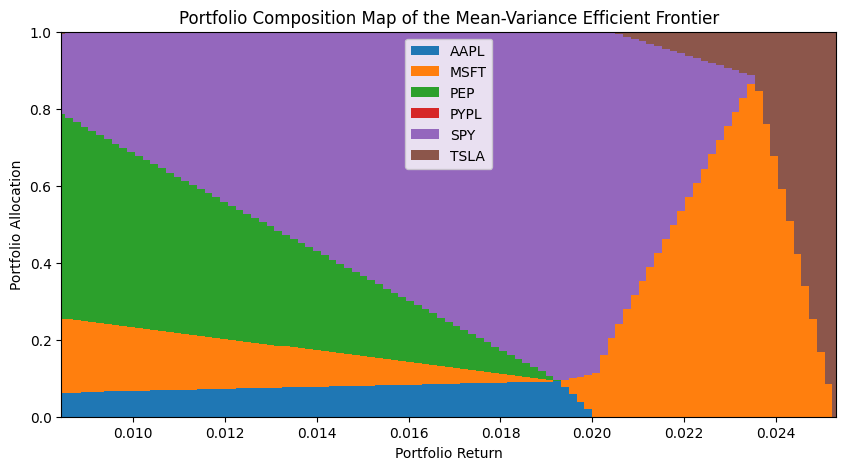

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bottom = np.zeros(ef_portfolios.shape[0])

# Ensure the plotting order matches the portfolio columns
for i, a in enumerate(assets):
    plt.bar(x=ef_returns,
            height=ef_portfolios[:, i],
            bottom=bottom,
            label=a,
            width=(ef_returns[1] - ef_returns[0]))
    bottom += ef_portfolios[:, i]

plt.legend()
plt.xlabel("Portfolio Return")
plt.xlim(float(ef_returns.min()), float(ef_returns.max()))
plt.ylabel("Portfolio Allocation")
plt.ylim(0, 1)
plt.title("Portfolio Composition Map of the Mean-Variance Efficient Frontier")
plt.show()

Save the portfolios in a TSV file named "efficient_frontier.tsv".
The header row should have columns "index", "return", "risk", and all the asset tickers.
Each data row should have the portfolio index (0-100), the estimated return of the portfolio, the estimated standard deviation (not variance) of the portfolio, and all the asset allocations (which should sum to one).

In [45]:
# YOUR CHANGES HERE

ef_risks = np.sqrt(ef_variances)

# Build DataFrame
ef_df = pd.DataFrame(ef_portfolios, columns=assets)
ef_df.insert(0, "risk", ef_risks)
ef_df.insert(0, "return", ef_returns)
ef_df.insert(0, "index", np.arange(len(ef_returns)))

# Allocations sum to 1 
assert np.allclose(ef_df[assets].sum(axis=1), 1.0, atol=1e-6)

# Save to TSV
ef_df.to_csv("efficient_frontier.tsv", sep="\t", index=False, float_format="%.6f")

Submit "efficient_frontier.tsv" in Gradescope.

## Part 8: Check Maximum Return Portfolio Stability

Check the stability of the maximum return portfolio by resampling the estimated risk/return model.

Repeat 1000 times -
1. Use `np.random.multivariate_normal` to generate 23 return samples using your previously estimated risks and returns.
2. Estimate the return of each asset using that resampled return history.
3. Check which asset had the highest return in those resampled estimates.

This procedure is a reduced and simplified version of the Michaud resampled efficient frontier procedure that takes uncertainty in the risk model into account.

In [46]:
# YOUR CHANGES HERE

# Standardize inputs 
if isinstance(estimated_returns, pd.DataFrame):
    mu_s = estimated_returns.set_index("asset")["return"].astype(float)
else:
    mu_s = pd.Series(estimated_returns, dtype=float)
assets = mu_s.index.tolist()
mu = mu_s.values.astype(float)

Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)
    .astype(float)
).values

Sigma = (Sigma + Sigma.T) / 2.0
eigvals = np.linalg.eigvalsh(Sigma)
min_eig = eigvals.min()
if min_eig < 1e-12:
    # add a small ridge to make it PSD
    Sigma += np.eye(Sigma.shape[0]) * (1e-8 - min_eig)

# Resample
B = 1000       # number of resamples
T = 23         # length of return history to simulate (differences of 24 prices)
rng = np.random.default_rng(704)

winner_counts = np.zeros(len(assets), dtype=int)

for _ in range(B):
    # simulate T monthly returns from MVN(mu, Sigma)
    sim = rng.multivariate_normal(mean=mu, cov=Sigma, size=T)  # shape (T, n_assets)
    sim_means = sim.mean(axis=0)                                # mean return per asset
    winner = int(np.argmax(sim_means))                          # index of top-mean asset
    winner_counts[winner] += 1

winner_share = winner_counts / B

stability_df = pd.DataFrame({
    "asset": assets,
    "wins": winner_counts,
    "share": winner_share
}).sort_values("share", ascending=False).reset_index(drop=True)

print(stability_df)

orig_best = mu_s.idxmax()
orig_best_share = float(stability_df.loc[stability_df["asset"] == orig_best, "share"])
print(f"\nOriginal max-return asset: {orig_best} — wins in {orig_best_share:.3f} of resamples.")


  asset  wins    share
0  TSLA   451 0.451000
1  MSFT   310 0.310000
2  AAPL    99 0.099000
3  PYPL    76 0.076000
4   SPY    62 0.062000
5   PEP     2 0.002000

Original max-return asset: TSLA — wins in 0.451 of resamples.


/tmp/ipykernel_13066/1401760613.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  orig_best_share = float(stability_df.loc[stability_df["asset"] == orig_best, "share"])


Save a file "max_return_probabilities.tsv" with the distribution of highest return assets.
The header row should have columns "asset" and "probability".
There should be a data row for each asset and its sample probability of having the highest return based on those 1000 resampled estimates.


In [ ]:
# YOUR CHANGES HERE

B = 1000  # number of resamples used

# Build probability DataFrame
prob_df = pd.DataFrame({
    "asset": assets,
    "probability": winner_counts / B
})

# Save to TSV 
prob_df.to_csv("max_return_probabilities.tsv", sep="\t", index=False, float_format="%.6f")

In [48]:
prob_df.head()

,asset,probability
0,AAPL,0.099000
1,MSFT,0.310000
2,PEP,0.002000
3,PYPL,0.076000
4,SPY,0.062000


In [49]:
prob_df.shape

(6, 2)

Submit "max_return_probabilities.tsv" in Gradescope.

## Part 9: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


In [50]:
with open("acknowledgments.txt", "w") as f:
    f.write("I only used Week 1 lecture code.\n")

Submit "acknowledgements.txt" in Gradescope.

## Part 10: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.